In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
df = pd.read_csv("amz_uk_price_prediction_dataset 2.csv")

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [18]:
#Create a crosstab between the product category and the isBestSeller status.
crosstab = pd.crosstab(df['category'], df['isBestSeller']).sort_values(by=True, ascending=True)
crosstab

crosstab['percantage'] = (crosstab[True] / (crosstab[True] + crosstab[False])) * 100
crosstab = crosstab.sort_values(by='percantage', ascending=False)
crosstab

isBestSeller,False,True,percantage
category,,,
Grocery,9008,556,5.813467
Smart Home Security & Lighting,98,6,5.769231
Health & Personal Care,9017,552,5.768628
Mobile Phone Accessories,248,11,4.247104
Power & Hand Tools,8353,306,3.533895
...,...,...,...
USB Gadgets,349,0,0.000000
Printer Accessories,254,0,0.000000
External TV Tuners & Video Capture Cards,2738,0,0.000000


In [19]:
# Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(crosstab.iloc[:, :2])
chi2, p 

(36540.20270061387, 0.0)

In [20]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.
n = crosstab.iloc[:, :2].values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
cramers_v

0.08646709890892415

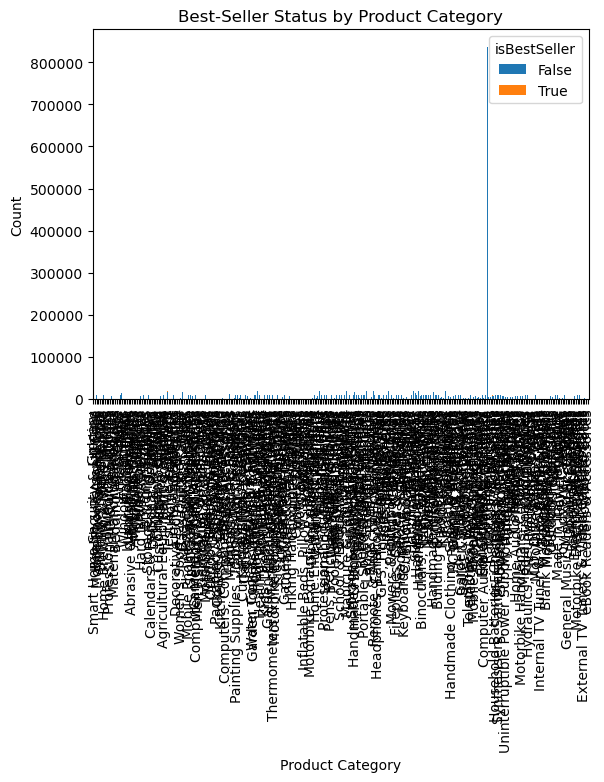

In [21]:
#Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
crosstab.iloc[:, :2].plot(kind='bar', stacked=True)
plt.title('Best-Seller Status by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.legend(title='isBestSeller', labels=['False', 'True'])
plt.show()

In [23]:
#For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
filter = (df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)
df = df.loc[filter]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2115963 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 147.3+ MB


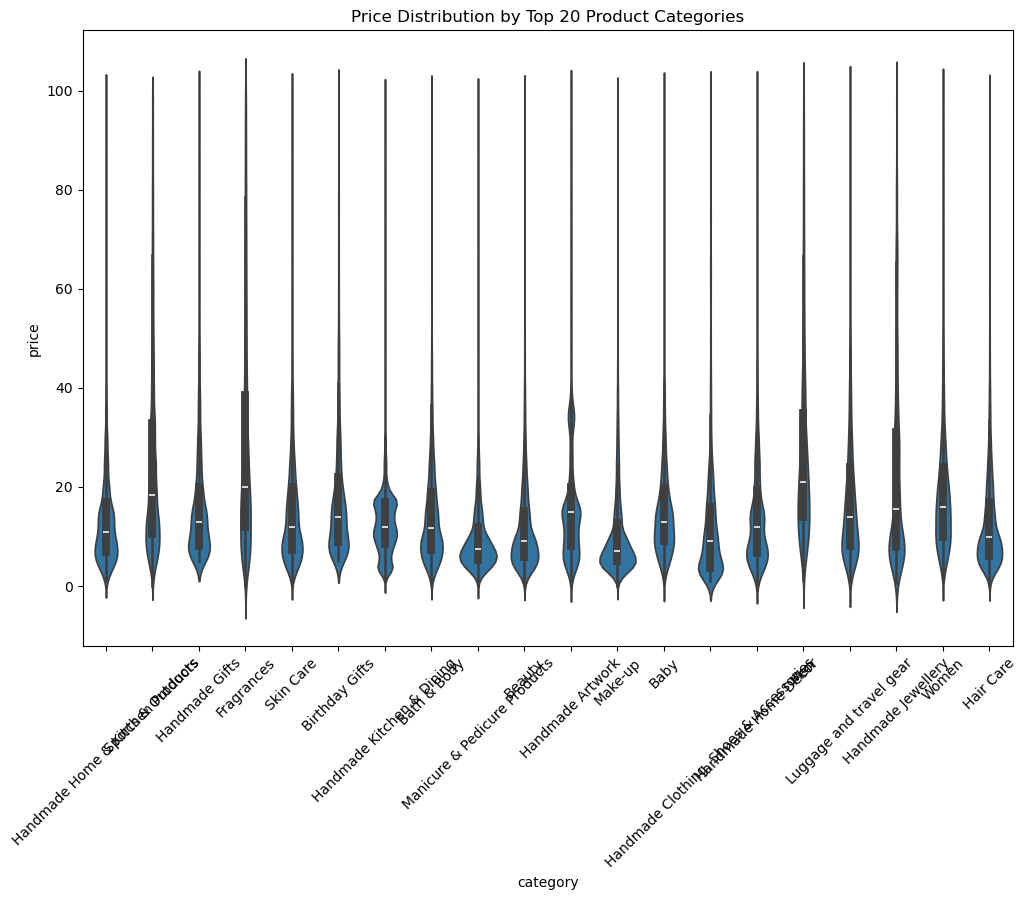

In [24]:
#Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
top_categories = df['category'].value_counts().nlargest(20).index
plt.figure(figsize=(12, 8))
sns.violinplot(data=df[df['category'].isin(top_categories)], x='category', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution by Top 20 Product Categories')
plt.show()

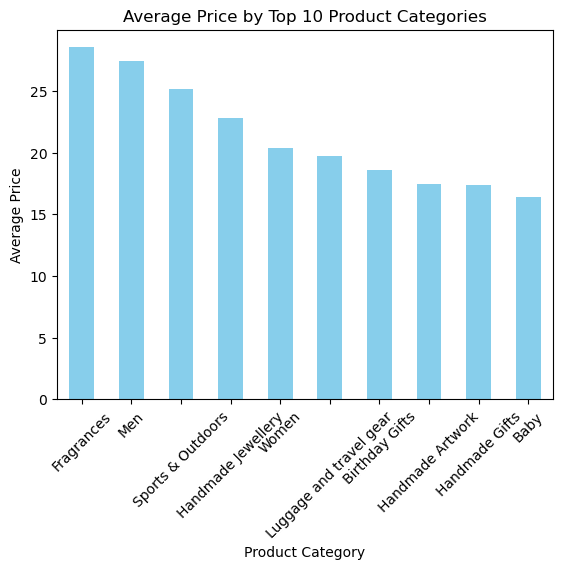

In [27]:
#Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
avg_price = df.groupby('category')['price'].mean().loc[top_categories].nlargest(10)
avg_price.plot(kind='bar', color='skyblue')
plt.title('Average Price by Top 10 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

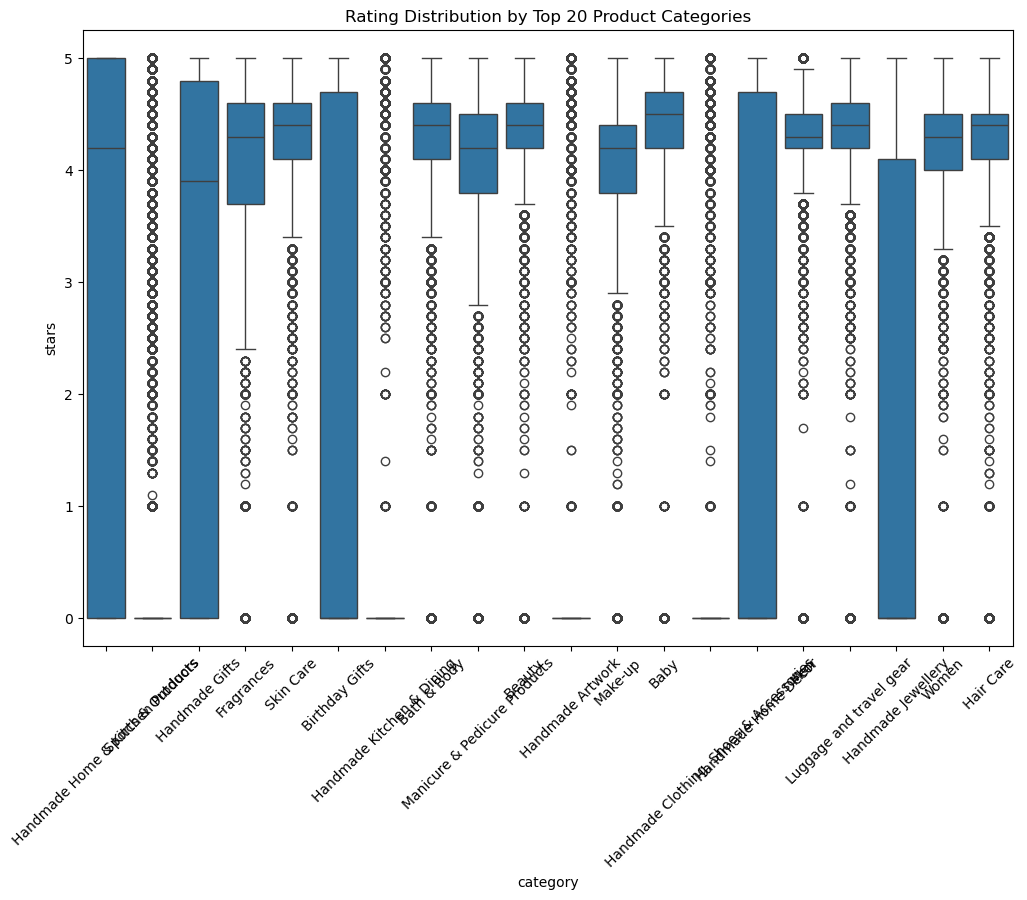

In [28]:
#Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[df['category'].isin(top_categories)], x='category', y='stars')
plt.xticks(rotation=45)
plt.title('Rating Distribution by Top 20 Product Categories')
plt.show()

In [29]:
# Calculate the correlation coefficient between price and stars
correlation = df['price'].corr(df['stars'])
correlation

-0.07767299878181444

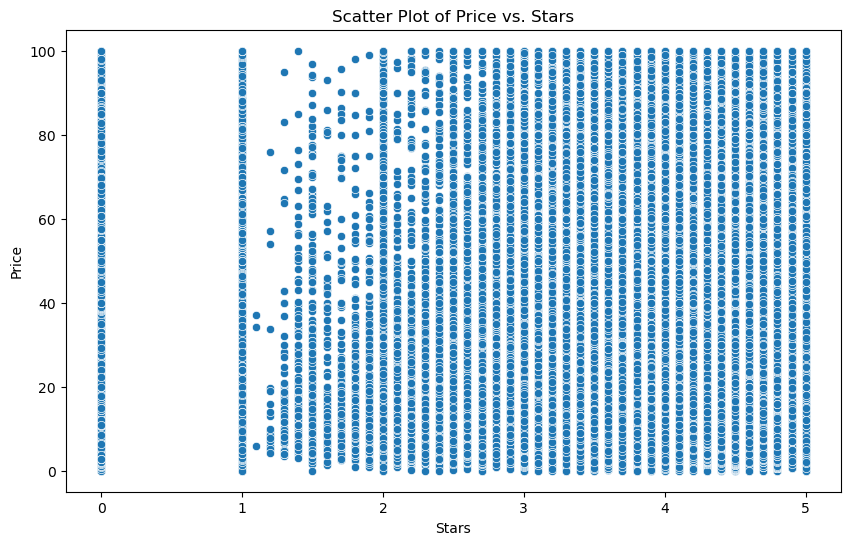

In [33]:
#Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='stars', y='price', alpha=1)
plt.title('Scatter Plot of Price vs. Stars')
plt.xlabel('Stars')
plt.ylabel('Price')
plt.show()

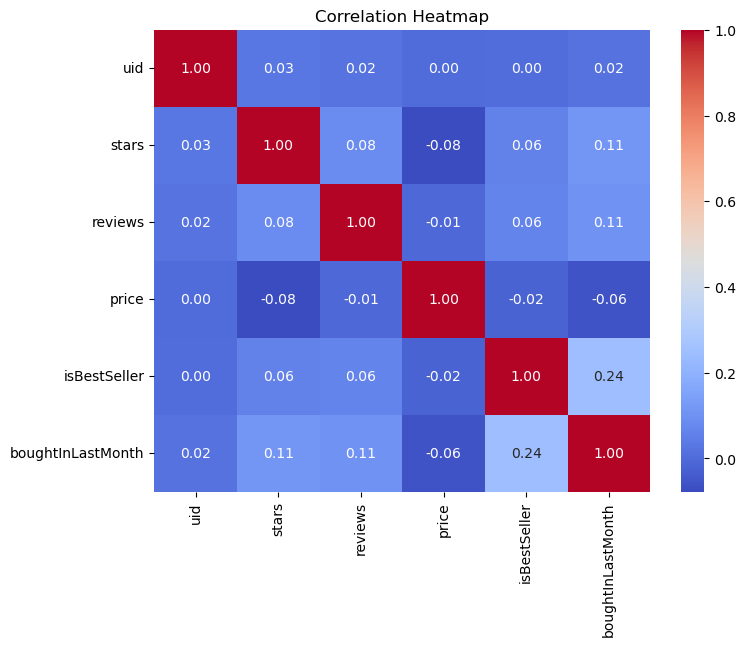

In [36]:
#Use a correlation heatmap to visualize correlations between all numerical variables
plt.figure(figsize=(8, 6))
correlation = df.corr(numeric_only=True)  # safer for mixed-type DataFrames
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

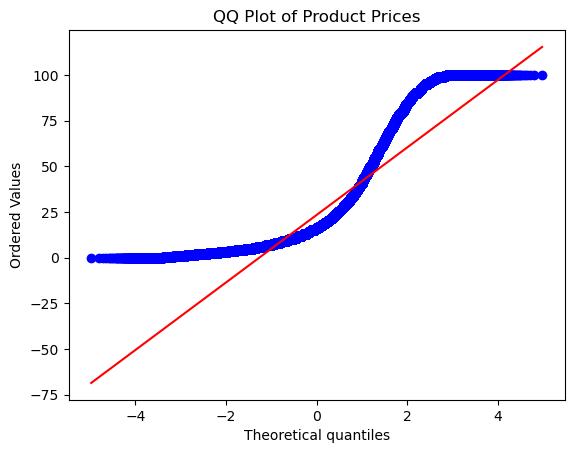

In [37]:
#Examine if product prices typically follow a normal distribution using a QQ plot.
# qq plot
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np 
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('QQ Plot of Product Prices')
plt.show()
